In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt

from pathlib import Path
from dataUtilities import filterData

In [5]:
### simple high pass fliter function
def filterData(x, kernelLength = 11, kernelFunction = 'flat'):

    if len(x) < kernelLength:
        raise ValueError("kernel length > data")
    
    if not kernelFunction in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("kernel function available are: 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    
    n = np.arange(kernelLength)
    h = np.sinc(2 * 0.1 * (n - (kernelLength - 1) / 2))
    
    # flat corresponds to a moving average filter
    if kernelFunction == "flat":
        kernel = np.ones(kernelLength)
    else:
        kernel = eval('np.' + kernelFunction + '(' + str(kernelLength) + ')')

    h = h * kernel
    h = h / np.sum(h)
    h = -h
    h[(kernelLength - 1) // 2] += 1
    
    return np.convolve(x, h, mode='valid')

In [6]:
def getIndices(time, fraction):
    cuttoff_time = time[-1] * fraction
    return np.where(time >= cuttoff_time, True, False)

def filterTest(time, x, filterType='hanning', filterWindow=11):
    print(filterType, filterWindow)
    if filterWindow % 2 == 0:
        raise Exception("filterWindow needs to be an uneven number!")

    mask = getIndices(time, 1/3)
        
    endTimeIndex = int(len(time[mask]) - ((filterWindow - 1)/2))        
                
    newTime =  time[int((filterWindow - 1)/2):endTimeIndex]
        
    filteredData = filterData(x[mask], filterWindow, filterType)

    return newTime, filteredData

In [9]:
t = np.linspace(0, 2, 200)
data = np.sin(3.21 * t)

newTime, filteredData = filterTest(t, data, 'hanning', 21)

print(newTime.shape, filteredData.shape)

hanning 21
(113,) (113,)


In [3]:
data_location = r'/home/mco143/Documents/Current_OpenFOAM_Simulations/fish_amplitude0_20'

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()

# get the individual cases
cases = []
forceBin_case = forceBins_paths[0].parts[-7]
cases.append(forceBin_case)
for forceBins_file in forceBins_paths:
    if forceBins_file.parts[-7] != forceBin_case:
        cases.append(forceBins_file.parts[-7])
        forceBin_case = forceBins_file.parts[-7]

# get the all the folders inside the cases
strouhals = []
for forceBins_file in forceBins_paths:
    if forceBins_file.parts[-7] == cases[0]:
        strouhals.append(forceBins_file.parts[-6])
    else:
        break

# make a nice dict of all the file names based on parent case
caseDict = dict()
caseDict['Force'] = {}
caseDict['ForceBins'] = {}
for case in cases:
    caseDict['Force'][case] = {}
    caseDict['ForceBins'][case] = {}
    for force_file in force_paths:
        if force_file.parts[-7] == case:
            caseDict['Force'][case][force_file.parts[-6]] = force_file
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-7] == case:
            caseDict['ForceBins'][case][forceBins_file.parts[-6]] = forceBins_file



In [4]:
class ForceBins:

    def __init__(self,
                 inputpath,
                 cycles = 3.0,
                 total_cycles = 3.0,
                 average = True,
                 filterForces = True):

        self.force_path = Path(inputpath).parent.joinpath('forceBin.dat')
        self.moment_path = Path(inputpath).parent.joinpath('momentBin.dat')
        self.specific_case = self.force_path.parts[-6]
        self.parent_case = self.force_path.parts[-7]
        self.cycles = cycles
        self.total_cycles = total_cycles

        # all forces should be loaded by now
        # build a "nice" dict with the forces                    
   
        self.forces = {}
        self.moments = {}

        self.forceCoord_x, self.forceCoord_y, self.forceCoord_z, _rawForces = self._readForceBinFile(self.force_path)
        self.momentCoord_x, self.momentCoord_y, self.momentCoord_z, _rawMoments = self._readForceBinFile(self.moment_path)

        pos = iter(range(1,(9*self.bins)+1))

        self.forces["time"] = _rawForces[:,0]
        self.moments["time"] = _rawMoments[:,0]
        for num in range(self.bins):
            self.forces[num] = {}
            self.moments[num] = {}
            for forceType in ("total", "pressure", "viscous"):
                self.forces[num][forceType] = {}
                self.moments[num][forceType] = {}
                for component in "x", "y", "z":
                    currentPos = next(pos)
                    self.forces[num][forceType][component] = _rawForces[:,currentPos]
                    self.moments[num][forceType][component] = _rawMoments[:,currentPos]               
        if average:
            self.calculateAverageStd()
        if filterForces:
            self.filterForcesMoments()
            self.calculateFilteredAverageStd()

    # function to process force.dat files
    def _readForceBinFile(self, file_name):
        raw = []
        x_coords = []
        y_coords = []
        z_coords = []
        force_len = 0
        
        with open(file_name, 'r') as f:
            for line in f:
                tmp = [x.strip('(').strip(')') for x in line.split()]
                if len(tmp) == 0:
                    continue
                elif tmp[0] == '#' and len(tmp) == 1:
                    continue
                elif tmp[0] == '#' and tmp[1] == 'bins':
                    # this is meant as a check in case the solver fails at any timestep
                    self.bins = int(tmp[3])
                    force_len = self.bins * 9 + 1
                elif tmp[1] == "x":
                    data = tmp[4:]
                    x_coords.append([ float(i) for i in data ])
                elif tmp[0] == '#' and tmp[1] == 'y':
                    data = tmp[4:]
                    y_coords.append([ float(i) for i in data ])
                elif tmp[0] == '#' and tmp[1] == 'z':
                    data = tmp[4:]
                    z_coords.append([ float(i) for i in data ])
                elif tmp[0] == '#':
                    continue
                else:
                    try:
                        force_tmp = [ float(i) for i in tmp ]
                        if len(force_tmp) == force_len:
                            raw.append(force_tmp)
                    except:
                        print("could not convert string to float in line:")
                        print("\t" + line)
                        print("in file:")
                        print("\t" + file_name.name)

        raw = np.array(raw)       
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)
        z_coords = np.array(z_coords)

        return x_coords[0], y_coords[0], z_coords[0], raw

    # Returns an indices mask based based on the number of cycles that want to be plotted
    def _getIndices(self, dictType):
        if dictType == 'forces':
            cuttoff_time = self.forces['time'][-1] * ((self.total_cycles-self.cycles)/self.total_cycles)
            return np.where(self.forces['time'] >= cuttoff_time, True, False)
        else:
            cuttoff_time = self.moments['time'][-1] * ((self.total_cycles-self.cycles)/self.total_cycles)
            return np.where(self.moments['time'] >= cuttoff_time, True, False)
    
    def _getIndicesByTime(self, dictType, startTime, endTime):
        if dictType == 'forces':
            return np.logical_and(self.forces['time'] >= startTime, self.forces['time'] <= endTime)
        else:
            return np.logical_and(self.moments['time'] >= startTime, self.moments['time'] <= endTime)
    
    # calculates the average and standard deviation on unfiltered data
    def calculateAverageStd(self):

        self.averageForces = {}
        self.stdForces = {}

        self.averageMoments = {}
        self.stdMoments = {}

        force_mask = self._getIndices('forces')
        moment_mask = self._getIndices('moments')

        for num in range(self.bins):
            self.averageForces[num] = {}
            self.averageMoments[num] = {}
            self.stdForces[num] = {}
            self.stdMoments[num] = {}
            for forceType in ("total", "pressure", "viscous"):
                self.averageForces[num][forceType] = {}
                self.averageMoments[num][forceType] = {}
                self.stdForces[num][forceType] = {}
                self.stdMoments[num][forceType] = {}
                for component in ("x", "y", "z"):
                    self.averageForces[num][forceType][component] = np.average(self.forces[num][forceType][component][force_mask])
                    self.averageMoments[num][forceType][component] = np.average(self.moments[num][forceType][component][moment_mask])
                    self.stdForces[num][forceType][component] = np.std(self.forces[num][forceType][component][force_mask])
                    self.stdMoments[num][forceType][component] = np.std(self.moments[num][forceType][component][moment_mask])

        return {"forces" : { "average" : self.averageForces, "std" : self.stdForces },
                "moments" : { "average" : self.averageMoments, "std" : self.stdMoments} }

    # filters the data
    def filterForcesMoments(self, filterFunction = "flat", filterWindow = 11):
        if filterWindow % 2 == 0:
            raise Exception("filterWindow needs to be an uneven number!")

        force_mask = self._getIndices('forces')
        moment_mask = self._getIndices('moments')
        
        endTimeIndex_force = int(len(self.forces["time"][force_mask]) - ((filterWindow - 1)/2))
        endTimeIndex_moment = int(len(self.moments["time"][moment_mask]) - ((filterWindow - 1)/2))
        
                
        self.filteredForces = {}
        self.filteredMoments = {}
        self.filteredForces["time"] =  self.forces["time"][int((filterWindow - 1)/2):endTimeIndex_force]
        self.filteredMoments["time"] =  self.moments["time"][int((filterWindow - 1)/2):endTimeIndex_moment]
        
        for num in range(self.bins):
            self.filteredForces[num] = {}
            self.filteredMoments[num] = {}
            for forceType in ("total", "pressure", "viscous"):
                self.filteredForces[num][forceType] = {}
                self.filteredMoments[num][forceType] = {}
                for component in ("x", "y", "z"):
                    self.filteredForces[num][forceType][component] = filterData(self.forces[num][forceType][component][force_mask], filterWindow, filterFunction)
                    self.filteredMoments[num][forceType][component] = filterData(self.moments[num][forceType][component][moment_mask], filterWindow, filterFunction)

        return self.filteredForces, self.filteredMoments

    # Calculates the average and standard deviation on filtered data
    def calculateFilteredAverageStd(self):

        if hasattr(self, "filteredForces") == False:
            raise Exception("missing attribute filteredForces. Please run filterForces prior to calculateFilteredAveragesStd!")
        
        self.averageFilteredForces = {}
        self.stdFilteredForces = {}

        self.averageFilteredMoments = {}
        self.stdFilteredMoments = {}

        for num in range(self.bins):
            self.averageFilteredForces[num] = {}
            self.stdFilteredForces[num] = {}
            self.averageFilteredMoments[num] = {}
            self.stdFilteredMoments[num] = {}
            for forceType in ("total", "pressure", "viscous"):
                self.averageFilteredForces[num][forceType] = {}
                self.averageFilteredMoments[num][forceType] = {}
                self.stdFilteredForces[num][forceType] = {}
                self.stdFilteredMoments[num][forceType] = {}
                for component in ("x", "y", "z"):
                    # calculate average forces
                    self.averageFilteredForces[num][forceType][component] = np.average(self.filteredForces[num][forceType][component])
                    self.stdFilteredForces[num][forceType][component] = np.std(self.filteredForces[num][forceType][component])
                    # calculate average moments
                    self.averageFilteredMoments[num][forceType][component] = np.average(self.filteredMoments[num][forceType][component])
                    self.stdFilteredMoments[num][forceType][component] = np.std(self.filteredMoments[num][forceType][component])


        return { "forces" : { "average" : self.averageFilteredForces, "std" : self.stdFilteredForces},
                 "moments": { "average" : self.averageFilteredMoments, "std" : self.stdFilteredMoments}}

    def convertToCoefficient(self):
        pass

    def getForcesMinTime(self):
        print("min time is {}".format(self.forces["time"][0]))
        return self.forces["time"][0]

    def getMomentsMinTime(self):
        print("min time is {}".format(self.moments["time"][0]))
        return self.moments["time"][0]

    ## define a method for getting forces by time
    def getForcesByTime(self,  startTime = 0, endTime = 0, forceType = "total", forceComponent = "x"):
        mask = self._getIndicesByTime('forces', startTime, endTime)
        return self.forces[forceType][forceComponent][mask]

    ## define a method for getting moments by time
    def getMomentsByTime(self,  startTime = 0, endTime = 0, forceType = "total", forceComponent = "x"):
        mask = self._getIndicesByTime('moments', startTime, endTime)
        return self.moments[forceType][forceComponent][mask]

    def calcPowerCarangiform(self, density, amplitude, omega, waveNumber):
        if hasattr(self, "filteredForces") == False:
            raise Exception("missing attribute filteredForces. Please run filterForces prior to calcPowerCarangiform!")
        
        self.power = {'time':[], 'calcPower':[]}
        self.average_power = 0

        tmp_power = np.zeros((len(self.filteredForces['time']), self.bins))
        self.power['time'] = self.filteredForces['time']
        
        for num in range(self.bins):
            x = self.forceCoord_x[num]
            h_dot_t = (amplitude[0] + amplitude[1]*x + amplitude[2]*x**2) * omega * np.cos(omega*self.filteredForces['time'] + waveNumber * x)
            tmp_power[:, num] = (-self.filteredForces[num]['pressure']['y'] / density * h_dot_t ) + (self.filteredForces[num]['viscous']['y'] / density * h_dot_t)
        
        for tmp in tmp_power:
            self.power['calcPower'].append(np.sum(tmp))

        self.average_power = np.mean(self.power['calcPower'])

        return self.power, self.average_power

In [5]:
testForce_bins = [ForceBins(forceBin_path, 2.0, 3.0, True, True) for forceBin_path in forceBins_paths]

In [13]:
multi_power = []
multi_avg_power = []
case_label = []
for forceBin in testForce_bins:
    case_label.append(forceBin.specific_case)
    power, avg_power = forceBin.calcPowerCarangiform(1025, np.array([0.02, -0.08, 0.16]), 1.571, 6.28)
    multi_power.append(power)
    multi_avg_power.append(avg_power)

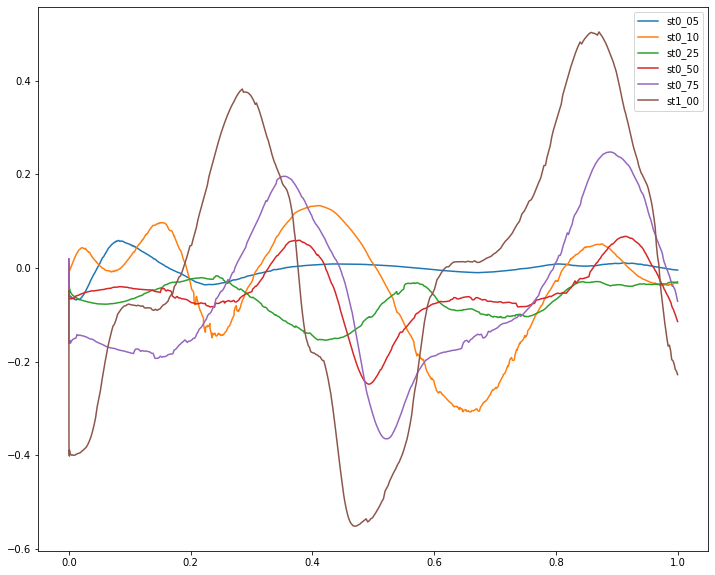

In [14]:
fig1, ax1 = plt.subplots(figsize=(12,10))
for i, power in enumerate(multi_power):
    ax1.plot(power['time']/power['time'][-1], power['calcPower'], label=case_label[i])

ax1.legend()

#x1.set_ylim([-1, 1])